In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from utils_contributions import *
import torch.nn.functional as F
from contributions import ModelWrapper, ClassificationModelWrapperCaptum, interpret_sentence_sst2
import contributions
import pandas as pd
import h5py
import json
import random
random.seed(10)

import codecs, json

import nltk
from nltk.corpus import stopwords

import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"

torch.cuda.set_device(3)
torch.cuda.current_device()

3

## Load model and tokenizer (BERT, DistilBERT, RoBERTa)

In [3]:
model_name = 'bert'
dataset_name = 'sst2'
model, tokenizer, dataset_partition = load_model_data(model_name,dataset_name)

Loading bert ...
Loading sst2 ...


Reusing dataset glue (/home/usuaris/veu/javier.ferrando/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


### Load dataset

In [4]:
sentence = dataset_partition[17] #403, 17, 1815, 1360, 1453

if dataset_name == 'sst2':
    text = sentence['sentence']

elif dataset_name == 'imdb':
    text = sentence['text']

In [5]:
# for i, sentence in enumerate(dataset_partition):
#     text = sentence['sentence']
#     if len(text)<100 and len(text)>60:
#         print(i)
#         print(text)

## Tokenize text

In [6]:
print(text)
pt_batch = tokenizer(text, return_tensors="pt").to(device)
tokenized_text = tokenizer.convert_ids_to_tokens(pt_batch["input_ids"][0])
print(tokenized_text)
seq_len = len(tokenized_text)

a remarkable 179-minute meditation on the nature of revolution .
['[CLS]', 'a', 'remarkable', '179', '-', 'minute', 'meditation', 'on', 'the', 'nature', 'of', 'revolution', '.', '[SEP]']


## Forward pass

In [7]:
model_wrapped = ModelWrapper(model)
prediction_scores, hidden_states, attentions, transformed_vectors_norm_model, contributions, transformed_vectors = model_wrapped(pt_batch)
probs = torch.nn.functional.softmax(prediction_scores, dim=-1)
print('probs',probs)
pred_ind = torch.argmax(probs)
pred = torch.max(probs)
pred

probs tensor([[4.5067e-04, 9.9955e-01]], device='cuda:3')


tensor(0.9995, device='cuda:3')

In [15]:
# LayerNorm = model.bert.encoder.layer[10].attention.output.LayerNorm
# ln_weight = LayerNorm.weight.cpu().detach().numpy()
# fig = plt.figure(figsize =(20,4))
# ax = fig.add_subplot(111)
# ax.bar(range(0,ln_weight.size),ln_weight)
# plt.xticks(ticks = range(0,ln_weight.size) ,labels = text, rotation = 45);

### Getting attention weights (attentions_mat), attention vector norms (model_norms) and contributions from our method (contributions)

In [16]:
_attentions = [att.detach().cpu().numpy() for att in attentions]
attentions_mat = np.asarray(_attentions)[:,0] # (num_layers,num_heads,src_len,src_len)
att_mat_sum_heads = attentions_mat.sum(axis=1)/attentions_mat.shape[1]
print(att_mat_sum_heads.shape)
normalized_model_norms = normalize_contributions(transformed_vectors_norm_model,scaling='sum_one')
normalized_contributions = normalize_contributions(contributions,scaling='min_sum')


(12, 14, 14)


### Rollout with attention weights (Abnar and Zuidema, 2020)

In [17]:
joint_attention_rollout = compute_rollout(att_mat_sum_heads)
joint_attention_rollout_cls = joint_attention_rollout[-1][0]
joint_attention_rollout = joint_attention_rollout.cpu().detach().numpy()

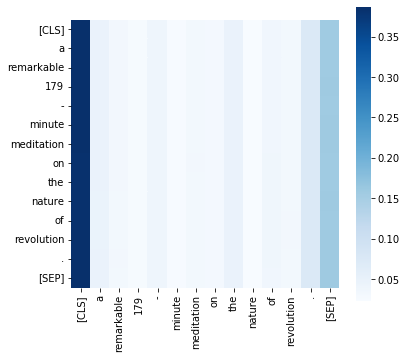

In [18]:
layer = -1
plt.figure(figsize=(6,6))
df = pd.DataFrame(joint_attention_rollout[layer],columns=tokenized_text,index=tokenized_text)
sns.heatmap(df,cmap="Blues",square=True)
plt.gcf().subplots_adjust(bottom=0.2)

### Attention rollout + (Vector Norms + RES + LN) (Kobayashi et al., 2021)

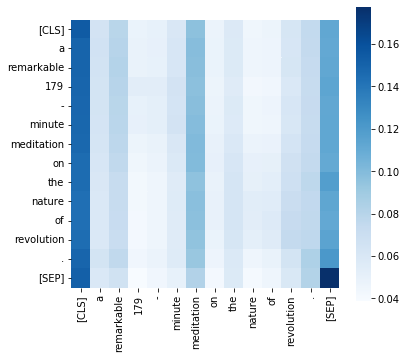

In [19]:
norms_mix = compute_joint_attention(normalized_model_norms)
norm_rollout_cls = norms_mix[-1][0]
norms_mix = norms_mix.detach().cpu().numpy()
plt.figure(figsize=(6,6))
joint_attention_layer = -1
df = pd.DataFrame(norms_mix[joint_attention_layer],columns=tokenized_text,index=tokenized_text)
sns.heatmap(df,cmap="Blues",square=True)
plt.gcf().subplots_adjust(bottom=0.2)


### Our approach

torch.float32


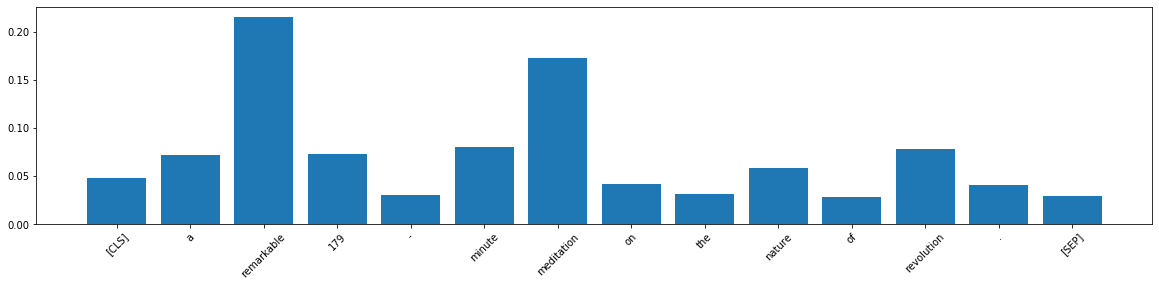

In [20]:
print(normalized_contributions.dtype)
contributions_mix = compute_joint_attention(normalized_contributions)
joint_attention_layer = -1
pos=0
contributions_mix_cls = contributions_mix[joint_attention_layer][pos]
plot_histogram(contributions_mix_cls,tokenized_text)


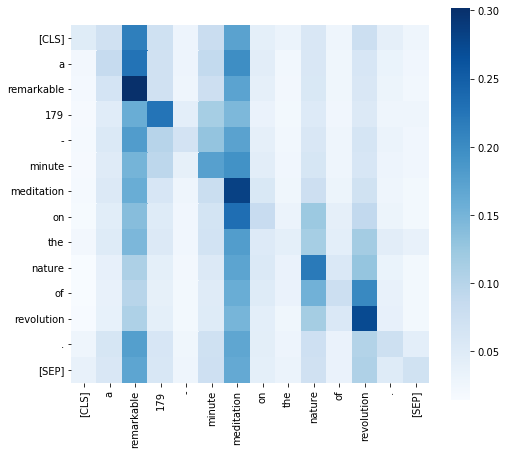

In [21]:
contributions_mix = contributions_mix.detach().cpu().numpy()
plt.figure(figsize=(8,8))

#joint_attention_normalized_layer = contributions_mix[joint_attention_layer] / joint_attentions[joint_attention_layer].sum(axis=-1)[...,None]
df = pd.DataFrame(contributions_mix[joint_attention_layer],columns=tokenized_text,index=tokenized_text)
sns.heatmap(df,cmap="Blues",square=True)#Reds,,center=0
plt.gcf().subplots_adjust(bottom=0.2)


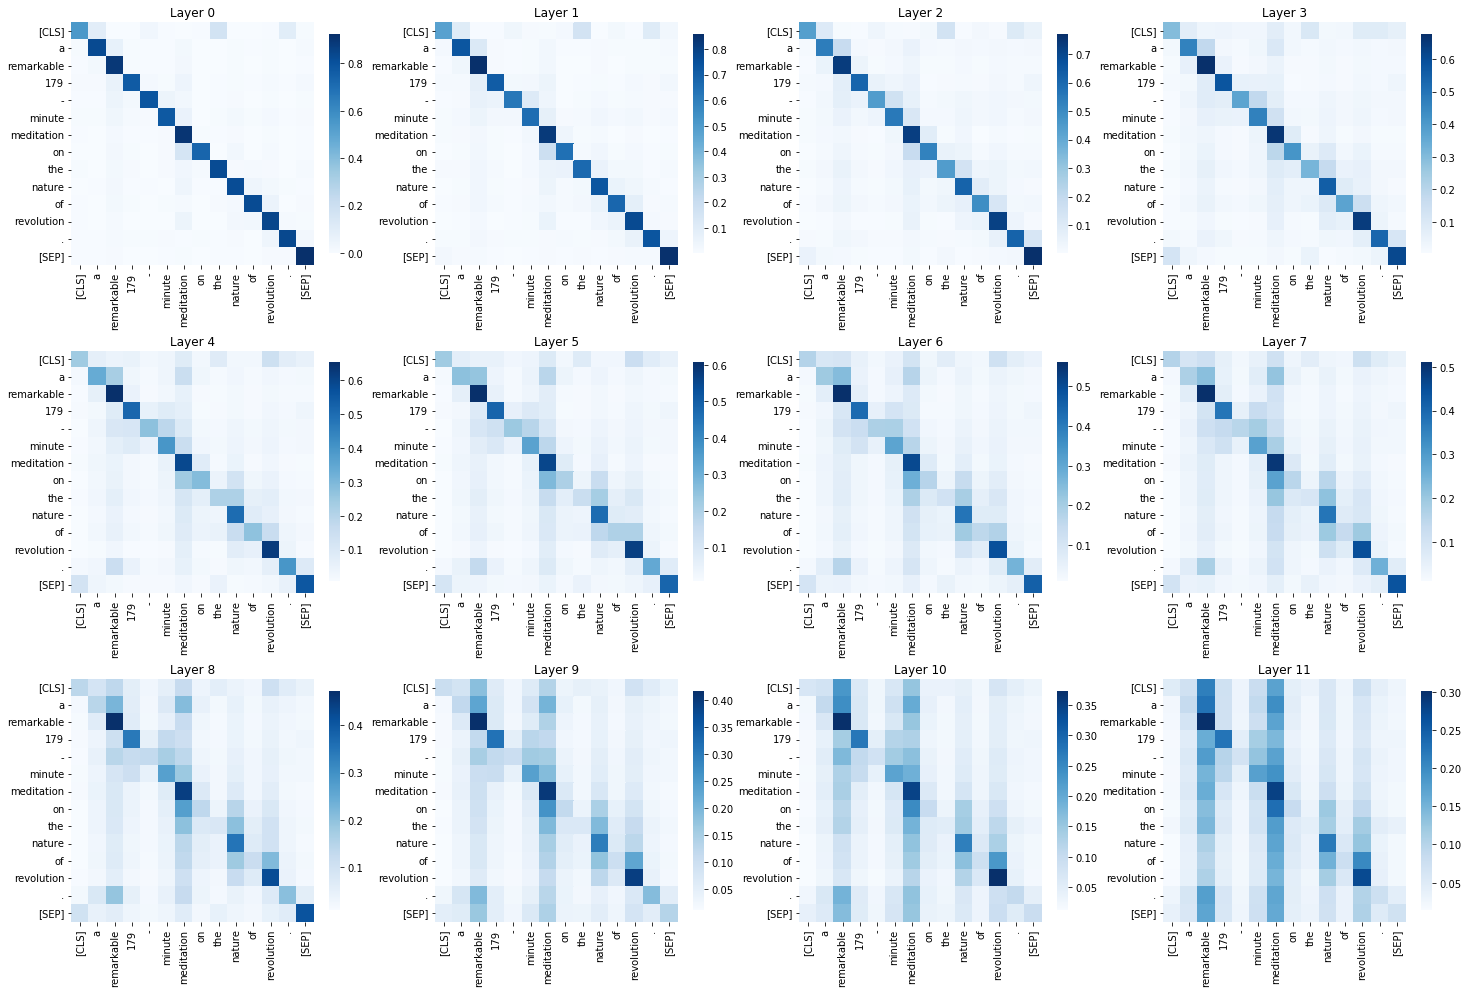

In [22]:
try:
    num_layers = model.config.num_hidden_layers
except:
    num_layers = model.config.n_layers

if num_layers == 12:
    fig, axs = plt.subplots(3, 4,figsize=(25,19),sharey=False)
    row = 4
    col = 4
elif num_layers == 6:
    fig, axs = plt.subplots(2, 3,figsize=(20,13),sharey=False)
    row = 3
    col = 3

for layer in range(0,num_layers):
    df = pd.DataFrame(contributions_mix[layer],columns=tokenized_text,index=tokenized_text)
    sns.heatmap(df,cmap="Blues",square=True,ax=axs[int(layer/row),layer%col],cbar_kws={'shrink': 0.8})
    axs[int(layer/row),layer%col].set_title('Layer ' + str(layer))
    axs[int(layer/row),layer%col].tick_params(axis='x', rotation=90)
    plt.gcf().subplots_adjust(bottom=0.2)

## Other attribution methods with Captum

In [24]:
## https://github.com/pytorch/captum/issues/150
   
bert_model_wrapper = ClassificationModelWrapperCaptum(model)


grad_attributions, predicted_class = interpret_sentence_sst2(bert_model_wrapper, tokenizer, sentence=text, method='grad')
grad_input_attributions, predicted_class = interpret_sentence_sst2(bert_model_wrapper, tokenizer, sentence=text, method='grad_input')
grad_ig_attributions, predicted_class = interpret_sentence_sst2(bert_model_wrapper, tokenizer, sentence=text, method='ig')


In [26]:
# accumalate couple samples in this array for visualization purposes
vis_data_records_ig = []

def add_attributions_to_visualizer(attributions, tokens, pred, label, vis_data_records):
    attributions_min_max = normalize_attribution_visualization(attributions)
    attributions_min_max = attributions_min_max.cpu().detach().numpy()

    
    # storing couple samples in an array for visualization purposes
    vis_data_records.append(visualization.VisualizationDataRecord(
                            attributions_min_max,
                            pred,
                            label,
                            label,
                            "label",
                            attributions_min_max.sum(),       
                            tokens[:len(attributions_min_max)],
                            0))
    return attributions_min_max

tokens = tokenizer.convert_ids_to_tokens(pt_batch["input_ids"][0].cpu().detach().numpy().tolist())
min_max_grad_attributions = add_attributions_to_visualizer(grad_attributions, tokens, pred, pred_ind, vis_data_records_ig)
min_max_grad_input_attributions = add_attributions_to_visualizer(grad_input_attributions, tokens, pred, pred_ind, vis_data_records_ig)
min_max_grad_ig_attributions = add_attributions_to_visualizer(grad_ig_attributions, tokens, pred, pred_ind, vis_data_records_ig)
#min_max_joint_attention_rollout_cls = add_attributions_to_visualizer(joint_attention_rollout_cls, tokens, pred, pred_ind, vis_data_records_ig)
#min_max_norm_rollout_cls = add_attributions_to_visualizer(norm_rollout_cls, tokens, pred, pred_ind, vis_data_records_ig)
min_max_contributions_mix_cls = add_attributions_to_visualizer(contributions_mix_cls, tokens, pred, pred_ind, vis_data_records_ig)

visualization.visualize_text(vis_data_records_ig);

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,1 (1.00),label,5.38,[CLS] a well - made and often lovely depiction of the mysteries of friendship . [SEP]
1,1 (1.00),label,5.13,[CLS] a well - made and often lovely depiction of the mysteries of friendship . [SEP]
1,1 (1.00),label,6.77,[CLS] a well - made and often lovely depiction of the mysteries of friendship . [SEP]
1,1 (1.00),label,6.33,[CLS] a well - made and often lovely depiction of the mysteries of friendship . [SEP]


## Prepare saliency maps for latex tables

In [59]:
attributions_list = []
attributions_list.append(min_max_grad_attributions)
attributions_list.append(min_max_grad_input_attributions)
attributions_list.append(min_max_grad_ig_attributions)
#attributions_list.append(min_max_joint_attention_rollout_cls)
#attributions_list.append(min_max_norm_rollout_cls)
attributions_list.append(min_max_contributions_mix_cls)
prepare_colorize()
figure_saliency(attributions_list, tokenized_text)


## Correlation between methods

In [ ]:
num_samples = 500

english_stopwords = stopwords.words('english')
stopwords_relevances = {}
stopwords_relevances['raw'] = []
stopwords_relevances['rollout'] = []
stopwords_relevances['rollout_norm'] = []
stopwords_relevances['our'] = []

special_tokens_relevances = {}
special_tokens_relevances['raw'] = []
special_tokens_relevances['rollout'] = []
special_tokens_relevances['rollout_norm'] = []
special_tokens_relevances['our'] = []

special_tokens = ['[CLS]','[SEP]','.',',']
special_tokens_roberta = ['<s>','</s>','\u0120'+'.','\u0120' + ',']
#special_tokens = ['the']

In [ ]:

layer = -1

relevances = {}
relevances['examples'] = []
relevances['raw'] = []
relevances['rollout'] = []
relevances['norm'] = []
relevances['ours'] = []

all_examples_x = []

# Random samples from test set (no duplicates)
random.seed(10)
random_samples_list = random.sample(range(len(dataset_partition)), num_samples)

for i in random_samples_list:
    
    model_wrapped = ModelWrapper(model)
    sentence = dataset_partition[i]
    text = sentence['sentence']
    pt_batch = tokenizer(text, return_tensors="pt").to(device)
    tokenized_text = tokenizer.convert_ids_to_tokens(pt_batch["input_ids"][0])
    relevances['examples'].append(tokenized_text)
    prediction_scores, hidden_states, attentions, transformed_vectors_norm_model, contributions, _ = model_wrapped(pt_batch)
    all_examples_x.append(pt_batch["input_ids"][0])

    # Raw attentions relevances    
    _attentions = [att.detach().cpu().numpy() for att in attentions]
    attentions_mat = np.asarray(_attentions)[:,0]
    raw_attn_relevances = get_raw_att_relevance(attentions_mat)
    relevances['raw'].append(np.asarray(raw_attn_relevances))
    raw_rank_normalized = get_normalized_rank(np.asarray(raw_attn_relevances))  

    # Rollout attentions relevances
    # Sum over heads
    att_mat_sum_heads = attentions_mat.sum(axis=1)/attentions_mat.shape[1]
    joint_attentions = compute_rollout(att_mat_sum_heads)
    rollout_relevance_relevances = joint_attentions[layer][0]
    relevances['rollout'].append(np.asarray(rollout_relevance_relevances))
    rollout_rank_normalized = get_normalized_rank(np.asarray(rollout_relevance_relevances))

    # Normalized model norms + roll out relevances
    normalized_model_norms = normalize_contributions(transformed_vectors_norm_model,scaling='sum_one')
    norms_mix = compute_joint_attention(normalized_model_norms)
    norms_mix_relevances = norms_mix[layer][0]
    relevances['norm'].append(np.asarray(norms_mix_relevances))
    rollout_norm_rank_normalized = get_normalized_rank(np.asarray(norms_mix_relevances))

    # Our method relevances
    normalized_contributions = normalize_contributions(contributions,scaling='min_sum')
    contributions_mix = compute_joint_attention(normalized_contributions)
    contributions_mix_relevances = contributions_mix[layer][0]
    relevances['ours'].append(np.asarray(contributions_mix_relevances))
    our_rank_normalized = get_normalized_rank(np.asarray(contributions_mix_relevances))

    # for x in english_stopwords:
    #     if x in tokenized_text:
    #         stopwords_relevances['raw'].append(raw_rank_normalized[tokenized_text.index(x)])
    #         stopwords_relevances['rollout'].append(rollout_rank_normalized[tokenized_text.index(x)])
    #         stopwords_relevances['rollout_norm'].append(rollout_norm_rank_normalized[tokenized_text.index(x)])
    #         stopwords_relevances['our'].append(our_rank_normalized[tokenized_text.index(x)])
    
    if model_name == 'roberta':
        special_tokens = special_tokens_roberta
    for x in special_tokens:
        if x in tokenized_text:
            special_tokens_relevances['raw'].append(raw_rank_normalized[tokenized_text.index(x)])
            special_tokens_relevances['rollout'].append(rollout_rank_normalized[tokenized_text.index(x)])
            special_tokens_relevances['rollout_norm'].append(rollout_norm_rank_normalized[tokenized_text.index(x)])
            special_tokens_relevances['our'].append(our_rank_normalized[tokenized_text.index(x)])

In [ ]:
stopwords_relevances['grad'] = []
stopwords_relevances['grad_input'] = []
stopwords_relevances['ig'] = []

special_tokens_relevances['grad'] = []
# special_tokens_relevances['grad_input'] = []
# special_tokens_relevances['ig'] = []

relevances['grad'] = []
relevances['grad_input'] = []
relevances['ig'] = []
relevances['pred_class'] = []

bert_model_wrapper = ClassificationModelWrapperCaptum(model)

for i in random_samples_list:
    sentence = dataset_partition[i]
    text = sentence['sentence']
    pt_batch = tokenizer(text, return_tensors="pt").to(device)
    tokenized_text = tokenizer.convert_ids_to_tokens(pt_batch["input_ids"][0])

    # Grad, grad input and ig relevances
    
    grad_relevance, pred_class= interpret_sentence_sst2(bert_model_wrapper, tokenizer, sentence=text, method='grad')
    relevances['pred_class'].append(pred_class.item())
    grad_relevance = grad_relevance.cpu().detach().numpy()
    relevances['grad'].append(grad_relevance)
    grad_rank_normalized = get_normalized_rank(grad_relevance)

    grad_x_input_relevance, _ = interpret_sentence_sst2(bert_model_wrapper, tokenizer, sentence=text, method='grad_input')
    grad_x_input_relevance = grad_x_input_relevance.cpu().detach().numpy()
    relevances['grad_input'].append(grad_x_input_relevance)
    grad_x_input_rank_normalized = get_normalized_rank(grad_x_input_relevance)

    ig_relevance, _ = interpret_sentence_sst2(bert_model_wrapper, tokenizer, sentence=text, method='ig')
    ig_relevance = ig_relevance.cpu().detach().numpy()
    relevances['ig'].append(ig_relevance)
    ig_relevance_rank_normalized = get_normalized_rank(ig_relevance)

    if model_name == 'roberta':
        special_tokens = special_tokens_roberta
    for x in special_tokens:
        if x in tokenized_text:
            special_tokens_relevances['grad'].append(grad_rank_normalized[tokenized_text.index(x)])
        # stopwords_relevances['grad_input'].append(grad_x_input_rank_normalized[tokenized_text.index(x)])
        # stopwords_relevances['ig'].append(ig_relevance_rank_normalized[tokenized_text.index(x)])


In [ ]:
outfile = f'./data/{model_name}_rank_relevances.npy'
np.save(outfile,relevances)

In [8]:
methods_list = ['raw','rollout','norm','ours','grad']

reference_method = 'grad'
for method in methods_list:
    print(relevances[method][0].shape, relevances[reference_method][0].shape)
    results_corr = []
    for i in np.arange(len(all_examples_x)):
        sp = spearmanr(relevances[method][i],relevances[reference_method][i])
        results_corr.append(sp[0])

    print(f'{method} vs  {reference_method}')
    print(np.mean(results_corr), np.std(results_corr))

(7,) (7,)
raw vs  grad
0.240067823054396 0.27405040310634105
(7,) (7,)
rollout vs  grad
0.014207750811659276 0.23897412019807243
(7,) (7,)
norm vs  grad
0.36535200031478093 0.21083510886409632
(7,) (7,)
ours vs  grad
0.6378101022773098 0.16262234752847005
(7,) (7,)
grad vs  grad
1.0 0.0


In [9]:
import statistics

for method in special_tokens_relevances.keys():
    print(method)
    print(statistics.mean(special_tokens_relevances[method]))
    print(statistics.stdev(special_tokens_relevances[method]))

# for method in stopwords_relevances.keys():
#     print(method)
#     print(statistics.mean(stopwords_relevances[method]))

raw
0.5034625715195405
0.28048049329439534
rollout
0.8269164810295064
0.2383954032240984
rollout_norm
0.8257592190728095
0.20393797122083004
our
0.2878350314258829
0.2075497268357593
grad
0.38825692912925774
0.2673961897000144


In [10]:
outfile = f'./data/{model_name}_special_tokens.json'
with open(outfile, 'w') as f:
    json.dump({
    'special_tokens_relevances' : special_tokens_relevances
    }, f)

## Analyzing isotropy

In [8]:
model_name = 'distilbert'
dataset_name = 'sst2'
get_cos_mean(model_name,dataset_name)

Loading distilbert ...
Loading sst2 ...


Reusing dataset glue (/home/usuaris/veu/javier.ferrando/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


In [32]:
import json
from matplotlib.lines import Line2D

plt.rcParams.update({'font.size': 16})
def visualize_transformed_space(model_names):
	"""Plot the baseline charts in the paper. Images are written to the img/ subfolder."""
	plt.figure(figsize=(12,4),dpi=600)
	#icons = [ 'ro:', 'bo:', 'go:']
	color = ['#82B366','#6C8EBF','#D79B00']

	for i, (model, num_layers) in enumerate([('distilbert', 6), ('bert', 12), ('roberta', 12)]):
		x = np.array(range(num_layers))
		data = json.load(open(f'cos_results/{model.lower()}_sst2_cos_results.json'))
		plt.plot(x, [ float(data["mean cosine similarity transformed vectors"][f'layer_{i}']) for i in x ], color[i], markersize=6, label=model_names[model], linewidth=2, linestyle='--',alpha = 1, marker='o')
		#plt.plot(x, [ float(data["mean cosine similarity embeddings"][f'layer_{i}']) for i in x ], icons[i], markersize=6, label=model, linewidth=2.5, alpha=0.65, linestyle='-')
		# print(spearmanr(
		# 	[ data["mean cosine similarity transformed vectors"][f'layer_{i}'] for i in x ],
		# 	[ data["word norm std"][f'layer_{i}'] for i in x ]
		# ))

	for i, spine in enumerate(plt.gca().spines.values()):
		if (i == 1) or (i==3):
			spine.set_visible(False)

	#plt.grid(False, linewidth=0.25)
	plt.legend(loc='upper left')
	plt.xlabel('Layer')
	plt.xticks(x)
	plt.ylim(0,1.0)
	plt.title("Cosine Similarity in Transformed Representations",fontsize='18')
	plt.savefig(f'img/sst2_mean_cosine_similarity_transformed.png', bbox_inches='tight')
	plt.close()

def visualize_embedding_space(model_names):
	"""Plot the baseline charts in the paper. Images are written to the img/ subfolder."""
    

	plt.figure(figsize=(12,4),dpi=600)
	#icons = [ 'ro:', 'bo:', 'go:']
	color = ['#82B366','#6C8EBF','#D79B00']

    

	for i, (model, num_layers) in enumerate([('distilbert', 7), ('bert', 13), ('roberta', 13)]):
        
		x = np.array(range(num_layers))
		data = json.load(open(f'cos_results/{model.lower()}_sst2_cos_results.json'))
		#plt.plot(x, [ float(data["mean cosine similarity transformed vectors"][f'layer_{i}']) for i in x ], icons[i], markersize=6, label=model, linewidth=2.5, alpha=0.65)
		plt.plot(x, [ float(data["mean cosine similarity embeddings"][f'layer_{i}']) for i in x ], color[i], markersize=6, label=model_names[model], linewidth=2, alpha=1,linestyle = '-',marker = 'o')
		# print(spearmanr(
		# 	[ data["mean cosine similarity transformed vectors"][f'layer_{i}'] for i in x ],
		# 	[ data["word norm std"][f'layer_{i}'] for i in x ]
		# ))

	for i, spine in enumerate(plt.gca().spines.values()):
		if (i == 1) or (i==3):
			spine.set_visible(False)

	#plt.grid(False, linewidth=0.25)
	plt.legend(loc='upper left')
	plt.xlabel('Layer')
	plt.xticks(x)
	plt.ylim(0,1.0)
	plt.title("Cosine Similarity in Layer Representations",fontsize='18')
	plt.savefig(f'img/sst2_mean_cosine_similarity_embeddings.png', bbox_inches='tight')
	plt.close()

model_names = {'distilbert' : 'DistilBERT', 'bert': 'BERT', 'roberta': 'RoBERTa'}

def visualize_joint_space(model_names):
	"""Plot the baseline charts in the paper. Images are written to the img/ subfolder."""
	plt.figure(figsize=(15,4),dpi=600)
	#icons = [ 'ro:', 'bo:', 'go:']
	color = ['#82B366','#6C8EBF','#D79B00']
	legend_elements = [Line2D([0], [0], color=color[0], lw=2, label=model_names['distilbert']),
                   Line2D([0], [0], color=color[1], lw=2, label=model_names['bert']),
                   Line2D([0], [0], color=color[2], lw=2, label=model_names['roberta'])]


	for i, (model, num_layers) in enumerate([('distilbert', 7), ('bert', 13), ('roberta', 13)]):
		x = np.array(range(num_layers))
		x_transf = np.array(range(num_layers-1))
		data = json.load(open(f'cos_results/{model.lower()}_sst2_cos_results.json'))
		plt.plot(x_transf, [ float(data["mean cosine similarity transformed vectors"][f'layer_{i}']) for i in x_transf ], color[i], markersize=6, label=model_names[model] + ' (T)', linewidth=2, linestyle='--',alpha = 1, marker='o')
		plt.plot(x, [ float(data["mean cosine similarity embeddings"][f'layer_{i}']) for i in x ], color[i], markersize=6, label=model_names[model], linewidth=2.5, alpha=0.65, linestyle='-', marker='v')

	for i, spine in enumerate(plt.gca().spines.values()):
		if (i == 1) or (i==3):
			spine.set_visible(False)

	#plt.grid(False, linewidth=0.25)
	#plt.legend(handles=legend_elements, loc='upper left')
	plt.legend(loc='upper left',prop={'size': 15})
	plt.xlabel('Layer')
	plt.xticks(x)
	plt.ylim(0,1.0)
	#plt.title("Average Cosine Similarity of Layer vs Transformed Representations",fontsize='18')
	plt.savefig(f'img/sst2_mean_cosine_similarity_transformed_joint.png', bbox_inches='tight')
	plt.close()





In [33]:
#visualize_transformed_space(model_names)
#visualize_embedding_space(model_names)
visualize_joint_space(model_names)

## Plot attribution to special tokens

In [34]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(16,4),dpi=600)#
plt.rcParams.update({'font.size': 16})
model_names = {'distilbert' : 'DistilBERT', 'bert': 'BERT', 'roberta': 'RoBERTa'}
labels = ['Attn Rollout', 'Norm Rollout', 'Gradl2', 'Ours']
color = ['#82B366','#6C8EBF','#D79B00']
pos = [-0.3,-0.1,0.1,0.3]
x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

for i, model_ in enumerate(model_names):
    values = []
    data =  json.load(open(f'./data/{model_}_special_tokens.json'))['special_tokens_relevances']
    values.append(statistics.mean(data['rollout']))
    values.append(statistics.mean(data['rollout_norm']))
    values.append(statistics.mean(data['grad']))
    values.append(statistics.mean(data['our']))

    plt.bar(x + pos[i], values, width,color=color[i] ,label=model_names[model_])


#plt.title("Average attribution scores to special tokens",fontsize='18')
plt.xlabel('Method')
plt.xticks(x-0.1,labels)
plt.ylim(0,1.0)
plt.legend(loc='upper right')
for i, spine in enumerate(plt.gca().spines.values()):
    if (i == 1) or (i==3):
        spine.set_visible(False)
plt.savefig(f'img/attributions_special_tokens.png', bbox_inches='tight')
plt.close()

#plt.show()

## Consistency BERT and DistilBERT

Check for each method its ranked importances in BERT vs DistilBERT

In [12]:
bert_file = f'./data/bert_rank_relevances.npy'
distilbert_file = f'./data/distilbert_rank_relevances.npy'
bert_data = np.load(bert_file,allow_pickle=True)[()]
distilbert_data = np.load(distilbert_file,allow_pickle=True)[()]

In [13]:
i = 110
bert_data['pred_class'][i] == distilbert_data['pred_class'][i]

True

In [14]:
methods_list = ['raw','rollout','norm','ours','grad','grad_input','ig']
results_corr = {}
counter = 0
for method in methods_list:
    if method == 'pred_class':
        pass
    results_corr[method] = []
    results_corr_tmp = []
    for i in range(len(bert_data['examples'])):
        # check for same tokenization
        bert_data_example = bert_data['examples'][i]
        distilbert_data_example = distilbert_data['examples'][i]
        if bert_data_example == distilbert_data_example:
            if bert_data['pred_class'][i] == distilbert_data['pred_class'][i]:
                counter += 1
                # print(bert_data_example)
                # print(distilbert_data_example)
                bert_data_rank_ex = get_normalized_rank(np.asarray(bert_data[method][i]))
                distilbert_data_rank_ex = get_normalized_rank(np.asarray(distilbert_data[method][i]))
                sp = spearmanr(bert_data_rank_ex,distilbert_data_rank_ex)
                results_corr_tmp.append(sp[0])
    

    print(f'{method}')
    print(np.mean(results_corr_tmp), np.std(results_corr_tmp))
    results_corr[method] = np.mean(results_corr_tmp)
    print(f'{counter} total results')

raw
0.5247801820656217 0.2672604923942747
468 total results
rollout
0.7322919756064518 0.11184498779881132
936 total results
norm
0.7714086673743012 0.14888041361409524
1404 total results
ours
0.7730552510347023 0.10354564958264525
1872 total results
grad
0.6467865436218838 0.17491365666882983
2340 total results
grad_input
0.07834414073281663 0.23566247576352306
2808 total results
ig
0.4436076691546144 0.19154356636473083
3276 total results


In [15]:
results_corr

{'raw': 0.5247801820656217,
 'rollout': 0.7322919756064518,
 'norm': 0.7714086673743012,
 'ours': 0.7730552510347023,
 'grad': 0.6467865436218838,
 'grad_input': 0.07834414073281663,
 'ig': 0.4436076691546144}

In [35]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(16,4),dpi=600)#
plt.rcParams.update({'font.size': 16})
method_names = {'grad_input' : 'Grad Input', 'ig': 'IG', 'grad': 'Gradl2', 'ours': 'Ours'}
labels = ['Grad Input', 'IG', 'Gradl2','Ours']
color = ['#0066CC','#B3B3B3','#B9E0A5','#CC0000']
#pos = [-0.3,-0.1,0.1,0.3]
x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars
values = []
for i, method in enumerate(method_names):
    data =  results_corr[method]
    values.append(data)

plt.bar(x, values, width,color='#1764AB')


#plt.title("Average attribution scores to special tokens",fontsize='18')
plt.xlabel('Method')
plt.xticks(x,labels)
plt.ylim(0,1.0)
#plt.legend(labels=list(method_names.values()),loc='upper left')
for i, spine in enumerate(plt.gca().spines.values()):
    if (i == 1) or (i==3):
        spine.set_visible(False)
plt.savefig(f'img/model_consistency.png', bbox_inches='tight')
plt.close()

#plt.show()